In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [3]:
NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

In [4]:
threshold = 0
column_to_predict = "kg_CO2/kWh"

independent_variables = []


for column in train:
    if abs(train[column].corr(train[column_to_predict])) > threshold:
        independent_variables.append(column)

independent_variables.remove(column_to_predict)
independent_variables.remove("Index")
independent_variables

['Hour_1',
 'Day Type_1',
 'Indoor Temperature (C)_1',
 'Average Unmet Cooling Setpoint Difference (C)_1',
 'Indoor Relative Humidity (%)_1',
 'Equipment Electric Power (kWh)_1',
 'DHW Heating (kWh)_1',
 'Cooling Load (kWh)_1',
 'Solar Generation (W/kW)_1',
 'Occupant Count (people)_1',
 'Temperature Set Point (C)_1',
 'Hour_2',
 'Day Type_2',
 'Indoor Temperature (C)_2',
 'Average Unmet Cooling Setpoint Difference (C)_2',
 'Indoor Relative Humidity (%)_2',
 'Equipment Electric Power (kWh)_2',
 'DHW Heating (kWh)_2',
 'Cooling Load (kWh)_2',
 'Solar Generation (W/kW)_2',
 'Occupant Count (people)_2',
 'Temperature Set Point (C)_2',
 'Hour_3',
 'Day Type_3',
 'Indoor Temperature (C)_3',
 'Average Unmet Cooling Setpoint Difference (C)_3',
 'Indoor Relative Humidity (%)_3',
 'Equipment Electric Power (kWh)_3',
 'DHW Heating (kWh)_3',
 'Cooling Load (kWh)_3',
 'Solar Generation (W/kW)_3',
 'Occupant Count (people)_3',
 'Temperature Set Point (C)_3',
 'Outdoor Drybulb Temperature (C)',
 'Ou

In [5]:
X_train = train[independent_variables]
# X_train = train[["Hour_1", "Day Type_1"]]
Y_train = train[column_to_predict]

In [6]:
X_train.shape

(648, 50)

In [30]:
def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        #print(f"i = {i}, seq = {seq}")
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        #print(f"i = {i}, target = {target}")
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [8]:
input_sequences, target_variables = create_sequences(X_train, Y_train, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
print(input_sequences[0])
print(target_variables[0])
print(input_sequences.shape)
print(target_variables.shape)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[[0.         0.66666667 0.42905032 ... 0.90353129 0.         0.        ]
 [0.04347826 0.66666667 0.30943362 ... 0.73034217 0.         0.        ]
 [0.08695652 0.66666667 0.30781619 ... 0.87445669 0.         0.        ]
 ...
 [0.91304348 0.83333333 0.29064017 ... 0.29065842 0.         0.        ]
 [0.95652174 0.83333333 0.04895782 ... 0.59164279 0.         0.        ]
 [1.         0.83333333 0.00208331 ... 0.53563308 0.         0.        ]]
[0.59739428 0.49429981 0.38708765 0.28880037 0.2346659  0.22880156
 0.26241434 0.31385395 0.36274065 0.32912399 0.41859464 0.59690114
 0.74685743 0.82796725 0.84589733 0.83725959 0.82125879 0.80709442
 0.78806505 0.73835998 0.71748058 0.73547528 0.69513525 0.71729728]
(577, 48, 50)
(577, 24)


In [9]:
# importing libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.optimizers import SGD

2023-11-27 21:20:14.097251: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 21:20:14.276625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 21:20:14.276668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 21:20:14.292313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 21:20:14.321177: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 21:20:14.321701: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [11]:
print(X_train.shape)

(648, 50)


In [37]:
# initializing the sequential RNN
model = keras.Sequential([
        
        # TODO I think this might be needed to group by timestamps rather than variables
        keras.layers.Permute((2,1), input_shape=(48,50)),
        
        # include a flatten layer to convert to 1D (used as a first layer instead of reshaping)
        keras.layers.Flatten(input_shape=(50,48)),
        # shape should be vertically, so 48 data points for x1, then x2...
        keras.layers.Dense(20, activation='tanh'),
        # keras.layers.Dropout(0.2),   no dropout yet
        keras.layers.Dense(20, activation='tanh'),
        keras.layers.Dense(10, activation='tanh'),
        keras.layers.Dense(24)
    ]) #amount of layers & neurons to be adjusted


# compiling RNN
model.compile(optimizer = SGD(learning_rate=0.01, 
                                  momentum=0.9, 
                                  nesterov=True), 
                  loss = "mean_squared_error")
 
# fitting the model
history = model.fit(input_sequences, target_variables, epochs = 100, verbose=1)
model.summary()


Epoch 1/100
19/19 [==============================] - 0s 1ms/step - loss: 0.2408
Epoch 2/100
19/19 [==============================] - 0s 1ms/step - loss: 0.1037
Epoch 3/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0581
Epoch 4/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0493
Epoch 5/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0471
Epoch 6/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0459
Epoch 7/100
19/19 [==============================] - 0s 951us/step - loss: 0.0447
Epoch 8/100
19/19 [==============================] - 0s 991us/step - loss: 0.0434
Epoch 9/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0425
Epoch 10/100
19/19 [==============================] - 0s 973us/step - loss: 0.0415
Epoch 11/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0403
Epoch 12/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0393
Epoch 13/100
19/19 [===========

In [35]:
# Prepare data for evaluation
X_test = test[independent_variables]
# X_test = train[["Hour_1", "Day Type_1"]]
Y_test = test[column_to_predict]

# Append last 24 hours from train
last_24_X = X_train.tail(24)
last_24_Y = Y_train.tail(24)

X_test = pd.concat([last_24_X, X_test], ignore_index=True)
Y_test = pd.concat([last_24_Y, Y_test], ignore_index=True)

eval_input_sequences, eval_target_variables = create_sequences(X_test, Y_test, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
print(Y_test)
print(eval_input_sequences.shape)
print(eval_target_variables.shape)

0     0.353082
1     0.256588
2     0.215438
3     0.201465
4     0.186162
        ...   
91    0.587037
92    0.607686
93    0.571493
94    0.508506
95    0.414290
Name: kg_CO2/kWh, Length: 96, dtype: float64
(25, 48, 50)
(25, 24)


In [39]:
# Evaluate the model on the test data
evaluation_result = model.evaluate(eval_input_sequences, eval_target_variables)
# TODO this just seems like the loss
print(evaluation_result)

# The evaluation result will be a list containing the loss value and accuracy
loss, accuracy = evaluation_result
print("Loss:", loss)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 13ms/step - loss: 0.0247
0.024746036157011986


TypeError: cannot unpack non-iterable float object

In [41]:
print(target_variables)

[[0.59739428 0.49429981 0.38708765 ... 0.73547528 0.69513525 0.71729728]
 [0.49429981 0.38708765 0.28880037 ... 0.69513525 0.71729728 0.6633147 ]
 [0.38708765 0.28880037 0.2346659  ... 0.71729728 0.6633147  0.55539687]
 ...
 [0.58203406 0.47630759 0.35308157 ... 0.72064381 0.72593017 0.70952622]
 [0.47630759 0.35308157 0.25658758 ... 0.72593017 0.70952622 0.60912381]
 [0.35308157 0.25658758 0.21543843 ... 0.70952622 0.60912381 0.49323911]]


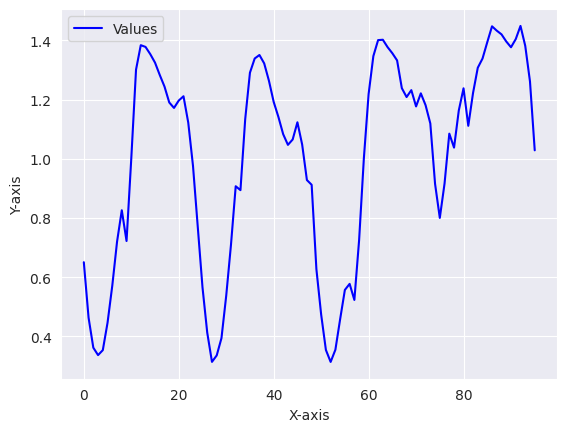

In [57]:
import matplotlib.pyplot as plt
import numpy as np

train_part = Y_train
original_test = Y_test
train_part.head()

original_data = pd.DataFrame()
original_data["Index"] = [i for i in range(len(Y_train) + len(Y_test))]
original_data["Values"] = Y_train + Y_test

# Specify different colors for each segment
colors = ['blue'] * len(Y_train) + ['orange'] * len(Y_test)

# Create a plot
original_data.plot(x="Index", y="Values", color=colors)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()


ValueError: could not convert string to float: 'index'

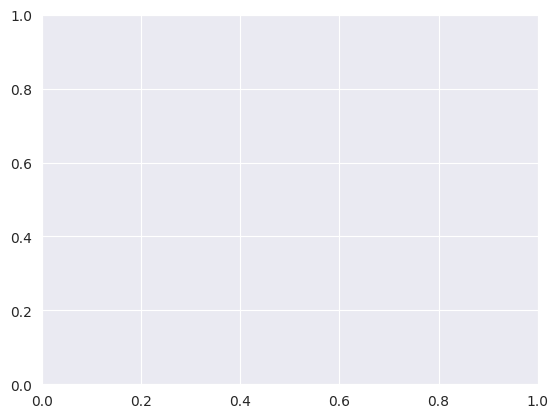

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Create a plot
plt.plot(Y_train, color='blue', label='Array 1')
plt.plot(Y_test, color='orange', label='Array 2')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# LSTM, GRU, MLP
# baseline is linear RNN

In [24]:
# initializing the LSTM
model_LSTM = keras.Sequential([
        
        # TODO I think this might be needed to group by timestamps rather than variables
        keras.layers.Permute((2,1), input_shape=(48,50)),
        
        # TODO does it make sense to stack them? should the number of units be equal to dimensions?
        keras.layers.LSTM(20, activation='tanh', return_sequences=True),
        # keras.layers.Dropout(0.2),   no dropout yet
        keras.layers.LSTM(20, activation='tanh', return_sequences=True),
        keras.layers.LSTM(10, activation='tanh', return_sequences=True),
        keras.layers.Dense(24)
    ]) #amount of layers & neurons to be adjusted


# compiling RNN
model_LSTM.compile(optimizer = SGD(learning_rate=0.01, 
                                  momentum=0.9, 
                                  nesterov=True), 
                  loss = "mean_squared_error")
 
# fitting the model
history_LSTM = model.fit(input_sequences, target_variables, epochs = 100, verbose=1)
model_LSTM.summary()

Epoch 1/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 2/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 3/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 4/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 5/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 6/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 7/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 8/100
19/19 [==============================] - 0s 998us/step - loss: 0.0097
Epoch 9/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 10/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 11/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 12/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 13/100
19/19 [===============